In [97]:
import pandas as pd
import xgboost as xgb

輸入資料

In [98]:
normalized_train = pd.read_csv('../result/all_beta_normalized_train_0.35.csv')

normalized_test = pd.read_csv('../result/all_beta_normalized_test_0.35.csv')

normalized_train_c = normalized_train[normalized_train['Unnamed: 0'].isin(normalized_test['Unnamed: 0'])]
normalized_train_c.shape

(388, 891)

In [99]:
X_train = normalized_train_c.iloc[:, 1::2]

x = []

for i in range(445):
    X = X_train.iloc[:, i]

    X = X.values.flatten().tolist()

    x.append(X)

y = [ (0 if i < 47 else 1)  for i in range(445)]

In [ ]:
from sklearn.model_selection import cross_val_score

# 將數據轉換為DMatrix格式
dmatrix = xgb.DMatrix(x, label=y)

# 定義模型參數
params = {
    'objective': 'binary:logistic',  # 二分類問題
    'eval_metric': 'logloss',  # 評估指標
    'max_depth': 3,
    'learning_rate': 1
}

# 建立模型
model = xgb.XGBClassifier(**params)

# 進行交叉驗證，這裡使用 5-fold 交叉驗證
cv_scores = cross_val_score(model, x, y, cv=5, scoring='accuracy')

# 印出每次交叉驗證的準確度
print("各次交叉驗證的準確度:", cv_scores)

# 計算平均準確度
average_accuracy = cv_scores.mean()
print("平均交叉驗證準確度:", average_accuracy)


In [ ]:
from itertools import combinations

target_labels = ['cg03520644','cg05047401','cg06355129','cg07790615','cg09106903']

# 三個一組
combinations_list = list(combinations(target_labels, 3))

acc=[]
# 所有可能的組合
for combination in combinations_list:
    #print(combination)
    d1_values = normalized_train.loc[normalized_train['Unnamed: 0']==combination[0]]
    d2_values = normalized_train.loc[normalized_train['Unnamed: 0']==combination[1]]
    d3_values = normalized_train.loc[normalized_train['Unnamed: 0']==combination[2]]
   
    d1 = d1_values.iloc[:, 1::2]
    d2 = d2_values.iloc[:, 1::2]
    d3 = d3_values.iloc[:, 1::2]

    d1 = d1.values.flatten().tolist()
    d2 = d2.values.flatten().tolist()
    d3 = d3.values.flatten().tolist()

    x = []

    for i in range(445):
        x.append([d1[i],d2[i],d3[i]])
        
    # 將數據轉換為DMatrix格式
    dmatrix = xgb.DMatrix(x, label=y)

    # 定義模型參數
    params = {
        'objective': 'binary:logistic',  # 二分類問題
        'eval_metric': 'logloss',  # 評估指標
        'max_depth': 3,
        'learning_rate': 1
    }

    # 建立模型
    model = xgb.XGBClassifier(**params)

    # 進行交叉驗證，這裡使用 5-fold 交叉驗證
    cv_scores = cross_val_score(model, x, y, cv=5, scoring='accuracy')

    # 印出每次交叉驗證的準確度
    #print("各次交叉驗證的準確度:", cv_scores)

    # 計算平均準確度
    average_accuracy = cv_scores.mean()
    #print("平均交叉驗證準確度:", average_accuracy)
    acc.append([combination[0],combination[1], combination[2], cv_scores[0],cv_scores[1],cv_scores[2],cv_scores[3],cv_scores[4], average_accuracy])


In [ ]:
df=pd.DataFrame(acc, columns=['ID1', 'ID2', 'ID3', 'fold_scores1','fold_scores2','fold_scores3','fold_scores4','fold_scores5', 'average_accuracy'])
df.to_csv("../result/xgb.csv", index=False)

使用RFECV決定最佳選擇位點數  
RFE 篩選到剩下RFECV決定的最佳選擇位點數，可得知最好的是哪一個位點、預測精準度

In [100]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.feature_selection import RFECV,RFE
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [123]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


models = {
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
}

results = pd.DataFrame(columns=['Model', 'Features', 'Accuracy'])

# 開始迴圈測試
for model_name, model in models.items():
    if model_name=='SVM':
            svc = SVC(kernel="linear")
            # 定義要測試的特徵數量
            feature_counts = [89]
            model=svc

    elif model_name=='Logistic Regression':
        logreg_clf = LogisticRegression()
        feature_counts = [23]
        model=logreg_clf

    elif model_name=='Decision Tree':
        dt_clf = DecisionTreeClassifier()
        feature_counts = [3]
        model=dt_clf

    elif model_name=='Random Forest':
        rf_clf = RandomForestClassifier()
        feature_counts = [355]
        model=rf_clf

    elif model_name=='XGBoost':
        xgb_clf = XGBClassifier()
        feature_counts = [2]
        model=xgb_clf

    for feature_count in feature_counts:

        # 使用 RFE 選擇特徵
        rfe = RFE(estimator=model, n_features_to_select=feature_count)
        X_train_rfe = rfe.fit_transform(X_train, y_train)

        selected_feature_indices = rfe.support_
        X_train_df = pd.DataFrame(X_train)
        selected_feature_names = normalized_train_c.iloc[selected_feature_indices,0]

        feature_ranking = rfe.ranking_
        # print("Feature Ranking:\n", feature_ranking)


        model.fit(X_train_rfe, y_train)

        # 在測試集上進行預測
        X_test_rfe = rfe.transform(X_test)
        y_pred = model.predict(X_test_rfe)

        accuracy = accuracy_score(y_test, y_pred)

        results = results.append({'Model': model_name, 'Features': feature_count,'Selected Features': selected_feature_names, 'Accuracy': accuracy}, ignore_index=True)


# 顯示結果
print(results)


                 Model Features  Accuracy  \
0                  SVM       89  1.000000   
1  Logistic Regression       23  1.000000   
2        Decision Tree        3  0.988764   
3        Random Forest      355  1.000000   
4              XGBoost        2  0.988764   

                                   Selected Features  
0  1      cg05047401
2      cg06355129
3      cg0...  
1  30     cg16768018
57     cg18675097
64     cg1...  
2  57     cg18675097
146    cg14231297
332    cg2...  
3  1      cg05047401
2      cg06355129
3      cg0...  
4  146    cg14231297
149    cg25352836
Name: Unna...  


In [122]:
results.to_csv("../result/RFE&ml.csv",index=False)

Optimal Number of Features: 89
Feature Rankings: [117   1   1   1   1  30 107  77 177  13 181   1 290 115   1  97 253 136
  24  81   1 133  92   1   1  36 294 130 175 172   1 225   1 287 241   1
 244 185 192  33   1 295   1 247   9   1  46 201  72  99 256  79   1  16
  45 270 227 252 138 114 153 135   1 215   1   1   1 210  10 200  55 139
  96 269 183 211 116  67 141   1 140   1  39 163 254  15  28 282   1 164
   1 199 137 128   1   1   1   1 161 208   1   1 158 205 240  60  57 186
  78 143   1 245 150   1  62 187 207   3 171 217 272 243 224 105   1  25
 226  95 275 297 283 299   1  38   1   1 182 155 206   1  12 191   1  82
 289   1   1   1 284   1   1  63  14  50  89  59  52  87   1 169  65   1
  94   1 250 121 286   1  47 273 276   1  93 271 223 145   1   1 300 156
 219   1 122 170   1 278 157 288   8  19 124 249 209  23 190 176  85   1
   2  37 103  26  56 216   1 127 281  20 131 263  84 266   1   5   1  80
  66 106 148   1  58   1  61  64  53   1 101 108 102 237 230 202  75   1
  

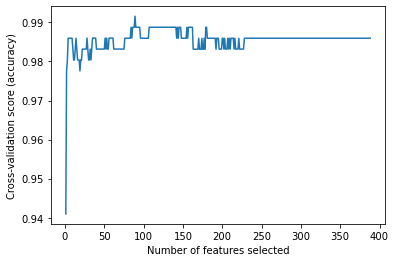

Optimal Number of Features: 23
Feature Rankings: [184  23  10 105  57 204 150 140 289 237 344  96 122 131  51 206  90 135
  59 220 124 218 100 291 145  44 267 182 185 253   1 197  68  93 300 167
 325 328 187 141  56 274  34 151 118 207 354  81 164  69 171 107 139  79
  58 321 153   1 138 282 126 154   5 133   1 111 306 127   9 287 168 194
 116 307 216 109   1  92 277  72 332   7  54 299 147  64 269 233   1 261
  28 340  30 189   1  18   1 114   1 225 123  48 256 112  74 335   3 155
 172 296  13 336 180   6 250 209 226 304 158 196 262 203 146 362  25 173
 337 309 254 360  83 283 183 324  19 163 323 221 175 223 275 144 177  35
 320  11  36   1 270  26  31  42  41 347  78 106 161 355   4  94 129  88
 170  17 286 343 264  12 302 364  89  14 192  43 294 241  45  53 137 327
  46  71  61  52   1 278  22 352  86  37  91 212 121  24 162 210  66   1
  20 191 259 219 195 165  77 227 322   1 353 236  73 318 213 281  47 198
  49  85 357  98  95   1  50 284  32   1 257  55 200 298 244 351 205 331
 2

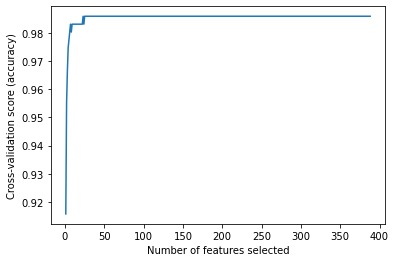

Optimal Number of Features: 3
Feature Rankings: [386 385 384 383 382 381 380 379 378 377 376 375 374 373 372 371 370 369
 368 367 366 365 364 363 362 361 360 359 358 357 356 355 354 353 352 351
 350 349 348 347 346 345 344 343 342 341 340 339 338 337 336 335 334 333
 332 331 330   1  14  16  10  13  12  11   9  18  20  22  24  26  28  30
  31  32  36  38  39  40  44  46  48  49  52  54  56  58  60  62  64  66
  68  70  71  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
 102 104 106 108 110 112 114 116 118 119 122 124 126 128 130 132 134 136
 138 140 142 144 146 148 150 152 154 156 158 160 162 164 166 168 170 172
 174 176   1 180 182 184 186 188 190 192 194 196 198 200 202 204 206 208
 210 212 214 216 218 220 222 224 226 228 230 232 234 236 238 240 242 244
 246 248 250 252 254 256 258 260 262 264 266 268 270 272 274 276 278 280
 282 284 286 287 290 292 294 296 298 300 302 304 306 308 310 312 314 316
 318 320 322 324 326 328 329 327 325 323 321 319 317 315 313 311 309 307
 30

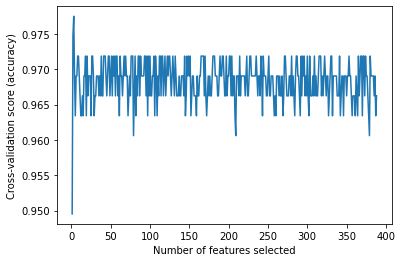

Optimal Number of Features: 355
Feature Rankings: [20  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1 33 27  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 23  4  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 15  1  1 26  1  1
  1  1 18  1  1  1  1  1  1  1  3 13  1  1  1  1  1  1  1  6  8  1 14 28
 29 34 21 25  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 31
 

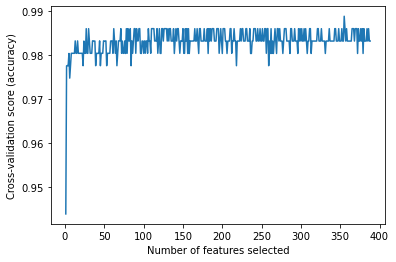

Optimal Number of Features: 2
Feature Rankings: [387   9  32  31  29  27  25  24  23  34  36  38  40  42  44  46  48  50
  52  54  56  58  60  62  64  66  68  70  72  74   4  78  80  82  84  86
  88  90  92  94  96  98 100 102 104 106 108 110 112 114 116 118 120 122
 124 126 128 130 132 134 136 138 140 142 144 146 148 150 152 154 156 158
 160 162 164 166 168 170 172 174 176 178 180 182 184 186 188 190 192 194
 196 198 200 202 204 206 208 210 212 214 216 218 220 222 224 226 228 230
 232 234 236 238 240  17 243 245 247 249 251 253 255 257 259 261 263 265
 267 269 271 273 275 277 279 281 283 285 287 289 291 293 295 297  21  11
 303 304   1   2 310   1 315 317 319 321 323 325 327 329 331 333 335 337
 339 341 343 345 347 349 351 353 355 357 359 361 363 365 367  19  75 373
 374  18 371 372  13 305 307 311  14 377 379 381 383 385 386 384 382  12
 370  26  28  30  22  33  35  37  39  41  43  45  47  49  51  53  55  57
   5  77  79  81  83  10  87  89  91  93  95   7  99 101 103 105 107 109
 11

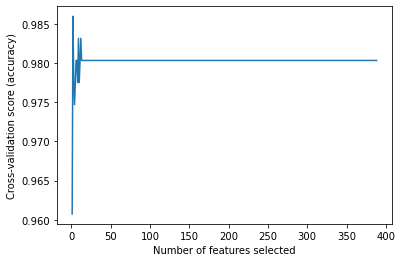

In [102]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

models = {
    'SVM': SVC(), #89
    'Logistic Regression': LogisticRegression(), #23
    'Decision Tree': DecisionTreeClassifier(), #3
    'Random Forest': RandomForestClassifier(), #355
    'XGBoost': XGBClassifier() #2
}


# 開始迴圈測試
for model_name, model in models.items():
    if model_name=='SVM':
            svc = SVC(kernel="linear")
            model=svc

    elif model_name=='Logistic Regression':
        logreg_clf = LogisticRegression()
        model=logreg_clf

    elif model_name=='Decision Tree':
        dt_clf = DecisionTreeClassifier()
        model=dt_clf

    elif model_name=='Random Forest':
        rf_clf = RandomForestClassifier()
        model=rf_clf

    elif model_name=='XGBoost':
        xgb_clf = XGBClassifier()
        model=xgb_clf

    # 初始化RFECV，cv參數是交叉驗證的次數，可以選擇StratifiedKFold或其他交叉驗證方法
    rfecv = RFECV(estimator=model, step=1, cv=5, scoring='accuracy')
    X_train_rfecv = rfecv.fit(X_train, y_train)

    print("Optimal Number of Features:", X_train_rfecv.n_features_)
    print("Feature Rankings:", X_train_rfecv.ranking_)
    print("Feature Select:",X_train_rfecv.support_)

    # 繪製特徵排名的圖表
    import matplotlib.pyplot as plt

    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross-validation score (accuracy)")
    plt.plot(range(1, len(X_train_rfecv.grid_scores_) + 1), X_train_rfecv.grid_scores_)
    plt.show()